In [12]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
# Assuming you have the file in your data/ folder
try:
    df = pd.read_csv('data/synthetic_demand_data.csv')
    df['order_date'] = pd.to_datetime(df['order_date'])
    print("Data loaded successfully.")
    print(df.head())
except FileNotFoundError:
    print("Error: synthetic_demand_data.csv not found in the 'data/' directory.")

Data loaded successfully.
  order_date    sku_id   location  quantity
0 2025-04-08  mango123     Mumbai        58
1 2025-04-08  mango123      Delhi        33
2 2025-04-08  mango123  Bangalore        25
3 2025-04-08  apple456     Mumbai        73
4 2025-04-08  apple456      Delhi        87


In [13]:
import os

# Get the current working directory
current_directory = os.getcwd()
print("Current Directory:", current_directory)

Current Directory: c:\Users\Prajwal\Desktop\Farm_to_plate\src\training


In [14]:
def create_features(df):
    """
    Creates time series features from a datetime index.
    """
    df_copy = df.copy()
    df_copy['day_of_week'] = df_copy['order_date'].dt.dayofweek
    df_copy['day_of_year'] = df_copy['order_date'].dt.dayofyear
    df_copy['month'] = df_copy['order_date'].dt.month
    df_copy['week_of_year'] = df_copy['order_date'].dt.isocalendar().week.astype(int)
    
    return df_copy

df = create_features(df)
print("\nData after creating time-based features:")
print(df.head())


Data after creating time-based features:
  order_date    sku_id   location  quantity  day_of_week  day_of_year  month   
0 2025-04-08  mango123     Mumbai        58            1           98      4  \
1 2025-04-08  mango123      Delhi        33            1           98      4   
2 2025-04-08  mango123  Bangalore        25            1           98      4   
3 2025-04-08  apple456     Mumbai        73            1           98      4   
4 2025-04-08  apple456      Delhi        87            1           98      4   

   week_of_year  
0            15  
1            15  
2            15  
3            15  
4            15  


In [15]:
# MODIFIED FUNCTION
def create_lag_rolling_features(df, drop_na=True):
    df_copy = df.copy()
    # Sort data to ensure lags and rolling windows are calculated correctly
    df_copy = df_copy.sort_values(by=['sku_id', 'location', 'order_date'])

    # Lag features (sales from previous periods)
    # We use groupby to calculate lags per item
    df_copy['lag_7'] = df_copy.groupby(['sku_id', 'location'])['quantity'].shift(7)
    df_copy['lag_14'] = df_copy.groupby(['sku_id', 'location'])['quantity'].shift(14)
    
    # Rolling window features (average sales over a past period)
    df_copy['rolling_mean_7'] = df_copy.groupby(['sku_id', 'location'])['quantity'].shift(1).rolling(window=7).mean()
    df_copy['rolling_mean_14'] = df_copy.groupby(['sku_id', 'location'])['quantity'].shift(1).rolling(window=14).mean()
    
    # Only drop rows with NaN if requested
    if drop_na:
        df_copy = df_copy.dropna().reset_index(drop=True)
    
    return df_copy

df_featured = create_lag_rolling_features(df)
print("\nData after creating lag and rolling features:")
print(df_featured.head(10))



Data after creating lag and rolling features:
  order_date    sku_id   location  quantity  day_of_week  day_of_year  month   
0 2025-04-22  apple456  Bangalore        69            1          112      4  \
1 2025-04-23  apple456  Bangalore        97            2          113      4   
2 2025-04-24  apple456  Bangalore        82            3          114      4   
3 2025-04-25  apple456  Bangalore       122            4          115      4   
4 2025-04-26  apple456  Bangalore       119            5          116      4   
5 2025-04-27  apple456  Bangalore        99            6          117      4   
6 2025-04-28  apple456  Bangalore        90            0          118      4   
7 2025-04-29  apple456  Bangalore        75            1          119      4   
8 2025-04-30  apple456  Bangalore       105            2          120      4   
9 2025-05-01  apple456  Bangalore        85            3          121      5   

   week_of_year  lag_7  lag_14  rolling_mean_7  rolling_mean_14  
0     

In [16]:
# Use pandas' get_dummies for one-hot encoding
df_final = pd.get_dummies(df_featured, columns=['sku_id', 'location'], drop_first=True)

# We can now drop the original date column as we have extracted features from it
df_final = df_final.drop('order_date', axis=1)

print("\nFinal DataFrame ready for training:")
print(df_final.head())
print("\nColumns:", df_final.columns)


Final DataFrame ready for training:
   quantity  day_of_week  day_of_year  month  week_of_year  lag_7  lag_14   
0        69            1          112      4            17   79.0    52.0  \
1        97            2          113      4            17   72.0    85.0   
2        82            3          114      4            17   81.0    76.0   
3       122            4          115      4            17  101.0    99.0   
4       119            5          116      4            17  129.0   129.0   

   rolling_mean_7  rolling_mean_14  sku_id_banana789  sku_id_mango123   
0       89.000000        86.500000             False            False  \
1       87.571429        87.714286             False            False   
2       91.142857        88.571429             False            False   
3       91.285714        89.000000             False            False   
4       94.285714        90.642857             False            False   

   location_Delhi  location_Mumbai  
0           False       

In [17]:
# Define the target variable and features
TARGET = 'quantity'
FEATURES = [col for col in df_final.columns if col != TARGET]

X = df_final[FEATURES]
y = df_final[TARGET]

# Let's use the last 10 days of data for validation
cutoff_point = df_featured['order_date'].max() - pd.Timedelta(days=10)
train_idx = df_featured[df_featured['order_date'] <= cutoff_point].index
test_idx = df_featured[df_featured['order_date'] > cutoff_point].index

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

Training data shape: (324, 12)
Test data shape: (90, 12)


In [18]:
# Initialize the XGBoost Regressor with some common hyperparameters
model = xgb.XGBRegressor(
    n_estimators=1000,      # Number of boosting rounds
    learning_rate=0.05,     # Step size shrinkage
    max_depth=5,            # Maximum depth of a tree
    subsample=0.8,          # Subsample ratio of the training instance
    colsample_bytree=0.8,   # Subsample ratio of columns when constructing each tree
    objective='reg:squarederror', # Specify the learning task and objective
    n_jobs=-1,              # Use all available CPU threads
    random_state=42
)

# Train the model with early stopping to prevent overfitting
# Early stopping will stop training if the validation score doesn't improve for N rounds
print("Training the XGBoost model...")
model.fit(X_train, y_train,
          eval_set=[(X_train, y_train), (X_test, y_test)],
          eval_metric='mae', # Mean Absolute Error
          early_stopping_rounds=50,
          verbose=100) # Print evaluation results every 100 rounds

Training the XGBoost model...
[0]	validation_0-mae:83.25074	validation_1-mae:101.44590


c:\Users\Prajwal\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\Prajwal\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-mae:4.31717	validation_1-mae:9.15386
[164]	validation_0-mae:2.95934	validation_1-mae:9.16445


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=42, ...)


--- Model Evaluation ---
Mean Absolute Error (MAE): 9.06
Root Mean Squared Error (RMSE): 11.16


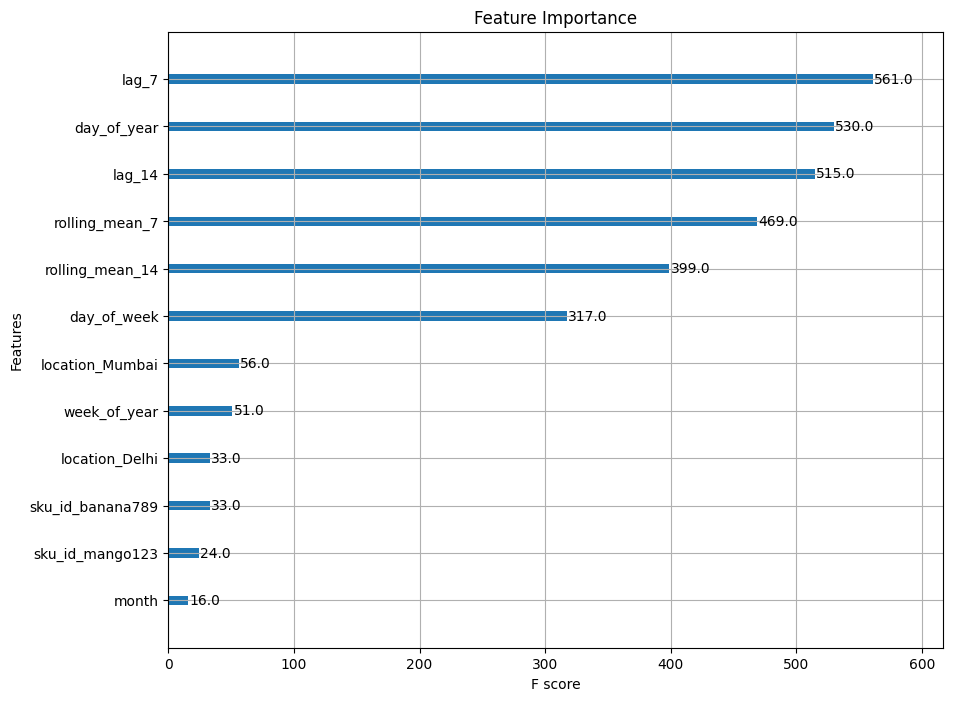

In [19]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate performance metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"\n--- Model Evaluation ---")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# Optional: Plot feature importance
fig, ax = plt.subplots(figsize=(10, 8))
xgb.plot_importance(model, ax=ax, max_num_features=15)
plt.title("Feature Importance")
plt.show()

In [20]:
# --- Re-train the model on the entire dataset ---
print("Re-training the final model on all available data...")

# Use the same model definition as before
final_model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    n_jobs=-1,
    random_state=42
)

# We use the full dataset X and y from Cell 5
# No need for early stopping here as we don't have a validation set
final_model.fit(X, y, verbose=False) 

print("Final model trained successfully.")

Re-training the final model on all available data...
Final model trained successfully.


In [22]:
from tqdm import tqdm # A nice progress bar for our loop

# --- Set up for forecasting ---
N_FORECAST_DAYS = 7
last_date = pd.to_datetime(df['order_date'].max())
skus = df['sku_id'].unique()
locations = df['location'].unique()

# Create a future dataframe with all combinations of future dates, skus, and locations
future_dates = [last_date + pd.DateOffset(days=i) for i in range(1, N_FORECAST_DAYS + 1)]
future_df = pd.DataFrame([(d, s, l) for d in future_dates for s in skus for l in locations], 
                         columns=['order_date', 'sku_id', 'location'])

# --- Recursive Forecasting Loop ---
# Use the last N days of historical data to create initial lags/rolling features
history_df = df_featured.copy()
predictions = []

print(f"\nGenerating forecast for the next {N_FORECAST_DAYS} days...")

for day in tqdm(range(N_FORECAST_DAYS)):
    # 1. Prepare the features for the current day we want to predict
    current_day_df = future_df[future_df['order_date'] == future_dates[day]]
    
    # Merge with history to get recent quantities for lag/rolling features
    # We need to go back far enough to calculate the largest lag/rolling window (14 days)
    merged_df = pd.concat([history_df, current_day_df], ignore_index=True)

    # 2. Create all features (time, lag, rolling)
    featured_day = create_features(merged_df)
    featured_day = create_lag_rolling_features(featured_day, drop_na=False) # <-- THE FIX
    
    # Filter to get only the rows for the day we are predicting
    prediction_input_df = featured_day[featured_day['order_date'] == future_dates[day]].copy()
    
    # 3. One-hot encode and align columns with the training data
    prediction_input_df_encoded = pd.get_dummies(prediction_input_df, columns=['sku_id', 'location'], drop_first=True)
    prediction_input_df_encoded = prediction_input_df_encoded.reindex(columns=X.columns, fill_value=0)
    
    # 4. Make the prediction
    daily_preds = final_model.predict(prediction_input_df_encoded)
    
    # 5. Store the prediction and update history for the next loop
    prediction_input_df['quantity'] = np.round(daily_preds).astype(int)
    # Ensure no negative predictions
    prediction_input_df['quantity'] = prediction_input_df['quantity'].clip(lower=0)
    
    # Append the day's predictions to our history
    history_df = pd.concat([history_df, prediction_input_df], ignore_index=True)
    # Append to our final predictions list
    predictions.append(prediction_input_df)

# Combine all daily predictions into a single DataFrame
final_forecast_df = pd.concat(predictions, ignore_index=True)

print("\n--- Forecast Generation Complete ---")
print(final_forecast_df[['order_date', 'sku_id', 'location', 'quantity']].head())


Generating forecast for the next 7 days...


100%|██████████| 7/7 [00:00<00:00, 11.79it/s]


--- Forecast Generation Complete ---
  order_date     sku_id   location  quantity
0 2025-06-07   apple456  Bangalore       153
1 2025-06-07   apple456      Delhi       176
2 2025-06-07   apple456     Mumbai       165
3 2025-06-07  banana789  Bangalore        97
4 2025-06-07  banana789      Delhi       135


In [23]:
import json
import pandas as pd # Make sure pandas is imported if in a new script

# Assuming 'final_forecast_df' is your DataFrame with the 7-day predictions
# It should look like this:
#    order_date     sku_id   location  quantity
# 0  2025-06-07   apple456  Bangalore       153
# 1  2025-06-07   apple456      Delhi       176
# 2  2025-06-07   apple456     Mumbai       165
# ...

# --- Step 1: Initialize an empty list to hold our JSON objects ---
output_data = []

print("--- Starting JSON formatting ---")

# --- Step 2: Group the DataFrame by SKU and Location ---
# The .groupby() method is perfect for this. It will create a separate group
# for each of the 9 unique combinations (e.g., ('apple456', 'Bangalore')).
grouped = final_forecast_df.groupby(['sku_id', 'location'])

# --- Step 3: Loop through each group to build the JSON objects ---
for (sku, loc), group_df in grouped:
    
    # Ensure the forecasts within each group are in chronological order
    sorted_group = group_df.sort_values('order_date')
    
    # Extract the 'quantity' column and convert it to a simple Python list
    forecast_list = sorted_group['quantity'].tolist()
    
    # Create the dictionary object in the desired format
    output_object = {
        "sku_id": sku,
        "location": loc,
        "forecast_next_7_days": forecast_list
    }
    
    # Add the newly created object to our main list
    output_data.append(output_object)

# --- Step 4: Define the output filename and save the data ---
output_filename = 'forecast_output.json'

try:
    with open(output_filename, 'w') as f:
        # json.dump() writes the Python list of dictionaries to the file
        # indent=4 makes the JSON file human-readable and "pretty"
        json.dump(output_data, f, indent=4)
    
    print(f"\nSUCCESS: Forecast data successfully saved to '{output_filename}'")

except Exception as e:
    print(f"\nERROR: An issue occurred while saving the file: {e}")


# --- Step 5: (Optional but Recommended) Print a sample to verify ---
if output_data:
    print("\n--- Sample of generated JSON ---")
    # json.dumps() converts a Python object to a JSON formatted string for printing
    print(json.dumps(output_data[0], indent=4))

--- Starting JSON formatting ---

SUCCESS: Forecast data successfully saved to 'forecast_output.json'

--- Sample of generated JSON ---
{
    "sku_id": "apple456",
    "location": "Bangalore",
    "forecast_next_7_days": [
        153,
        123,
        113,
        113,
        113,
        116,
        142
    ]
}
